<a href="https://colab.research.google.com/github/UmutSonmezz/ComputerVision/blob/main/Object_detection_with_Detectron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


İnstall **Detectron2**



In [ ]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [3]:
%cd /content/drive/MyDrive/Computer_Vision/Detectron2/small_card_dataset

/content/drive/MyDrive/Computer_Vision/Detectron2/small_card_dataset


In [ ]:
!unzip card_dataset.zip

In [4]:
%cd /content/drive/MyDrive/Computer_Vision/Detectron2/small_card_dataset/train

/content/drive/MyDrive/Computer_Vision/Detectron2/small_card_dataset/train


In [5]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances("customtrain1", {}, "/content/drive/MyDrive/Computer_Vision/Detectron2/small_card_dataset/train/_annotations.coco.json", "/content/drive/MyDrive/Computer_Vision/Detectron2/small_card_dataset/train")

In [6]:
sample_metadata = MetadataCatalog.get("customtrain1")
dataset_dicts = DatasetCatalog.get("customtrain1")

[10/13 19:54:26 d2.data.datasets.coco]: Loading /content/drive/MyDrive/Computer_Vision/Detectron2/small_card_dataset/train/_annotations.coco.json takes 3.90 seconds.
WARNING [10/13 19:54:26 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[10/13 19:54:26 d2.data.datasets.coco]: Loaded 954 images in COCO format from /content/drive/MyDrive/Computer_Vision/Detectron2/small_card_dataset/train/_annotations.coco.json


In [ ]:
!ls

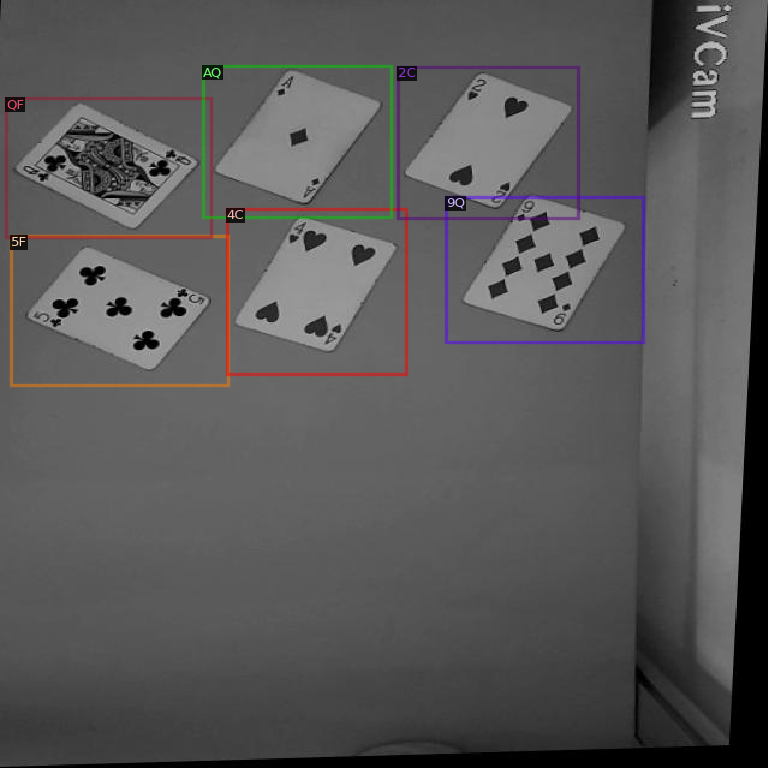

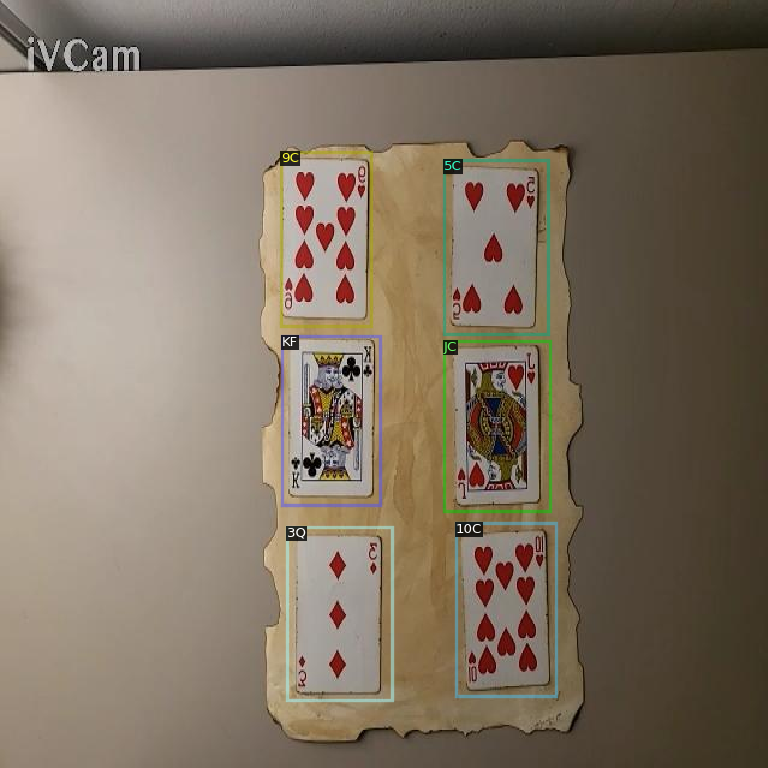

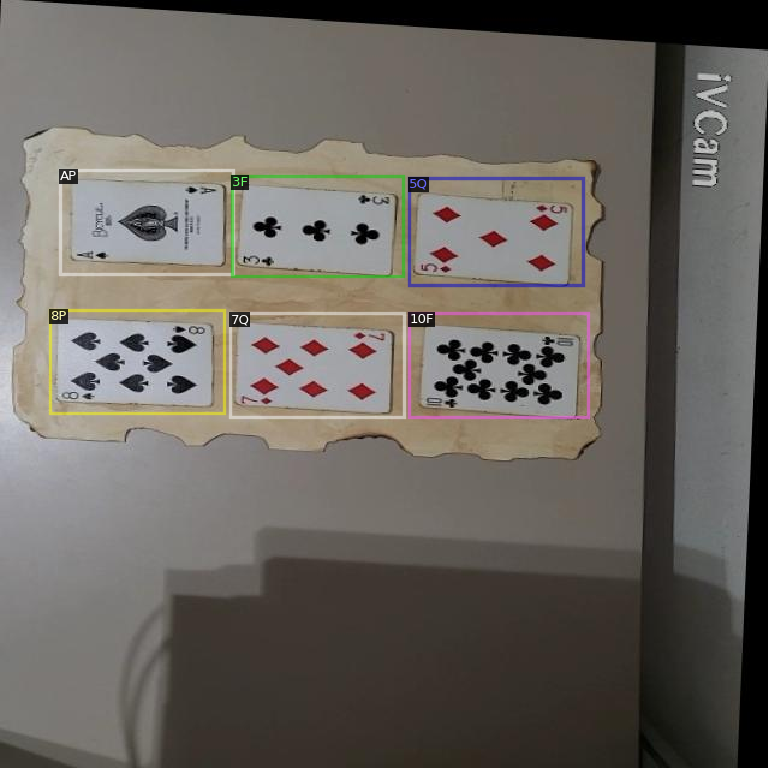

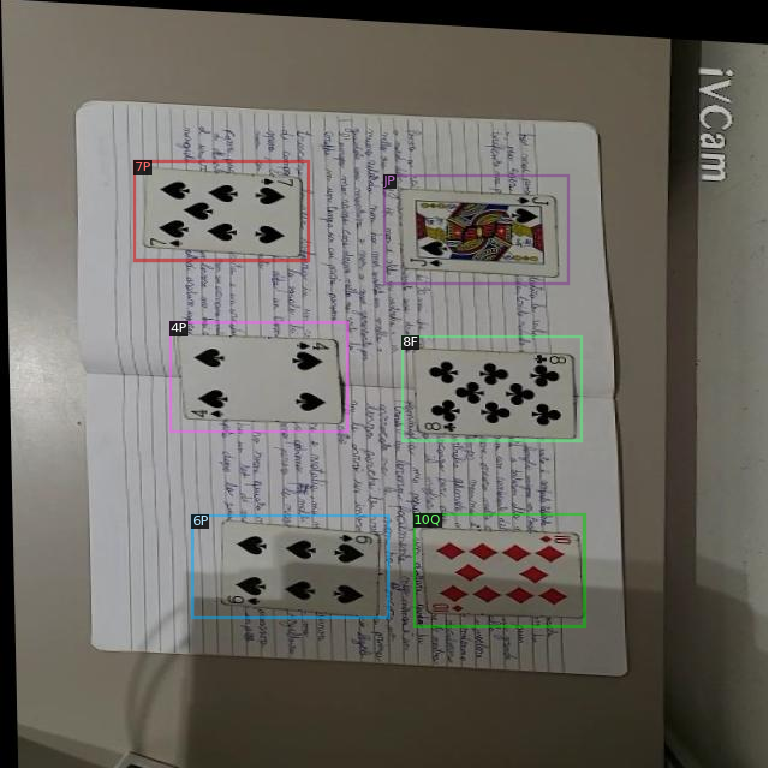

In [8]:
import random

for d in random.sample(dataset_dicts, 4):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=sample_metadata, scale=1.2)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [9]:
%cd /content/drive/MyDrive/Computer_Vision/Detectron2/small_card_dataset/train

/content/drive/MyDrive/Computer_Vision/Detectron2/small_card_dataset/train


**TRAİNİNG**

In [ ]:
import os
annotation_file = "/content/drive/MyDrive/Computer_Vision/Detectron2/small_card_dataset/train/_annotations.coco.json"
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
cfg = get_cfg()
cfg.DATASETS.ANNOTATION_FILE = annotation_file
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("customtrain1",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS =2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025  # pick a good LR
cfg.SOLVER.MAX_ITER = 500  # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 52  # (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

In [17]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4  # set the testing threshold for this model
cfg.DATASETS.TEST = ("/content/drive/MyDrive/Computer_Vision/Detectron2/small_card_dataset/test", )
predictor = DefaultPredictor(cfg)

[10/13 20:20:43 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

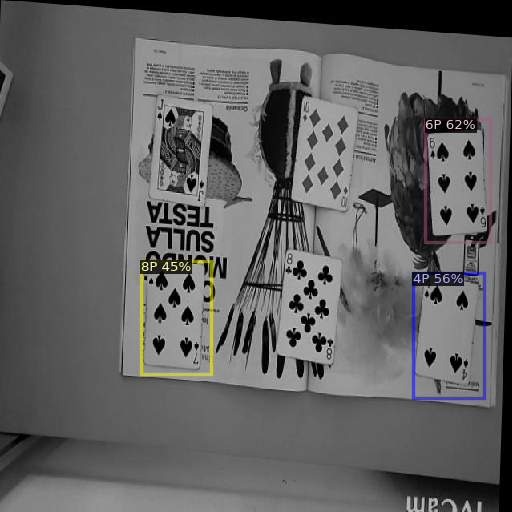

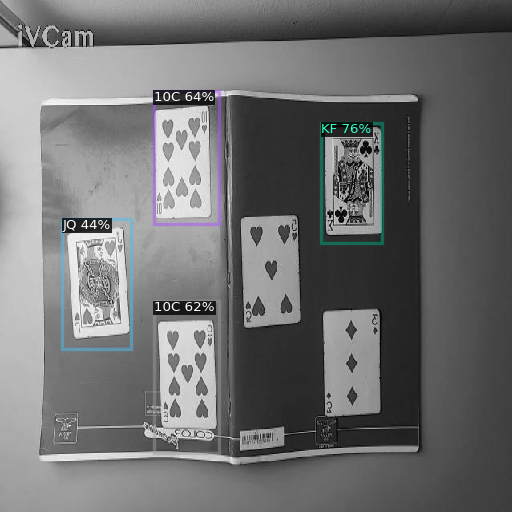

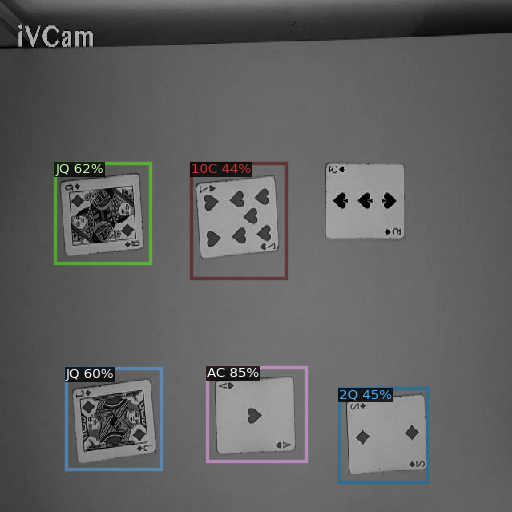

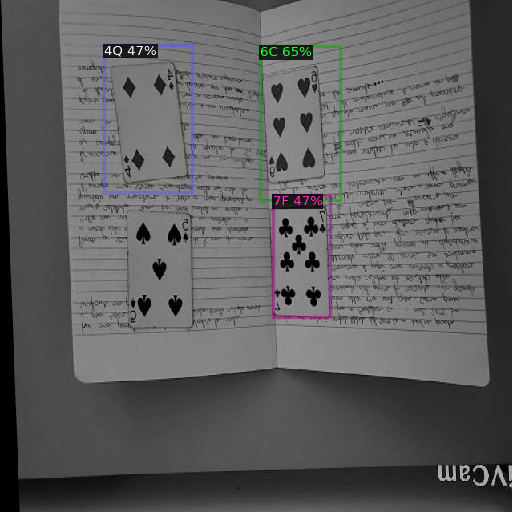

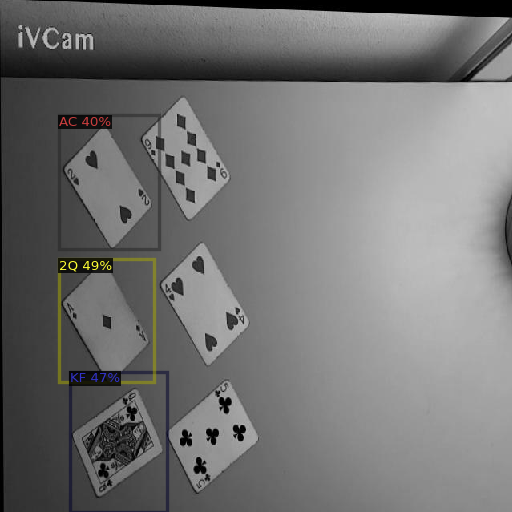

In [18]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 5):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=sample_metadata,
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])